## <center>去噪自编码 & 栈式自编码</center>

### 1 去噪自编码器
要想取得好的特征只靠重构输入数据还不够,在实际应用中,还需要让这些特征具有抗干扰的能力,即当输入数据发生一定程度的扰动时,生成的特征任然保持不变.在模型训练过程中添加噪声,这种情况下训练的而模型具有更好的鲁棒性,这种自编码器叫做去噪自动编码器

去噪自动编码器(Denoising Autoencoder,DA),是在自动编码器的基础上,训练数据加入噪声,输出的标签仍然是原始样本,通过这种方式学习输入信号更加鲁棒,具有更强的泛化能力.加入额外的噪声主要有两种途径:
+ (1) 在选择训练数据时,额外选择一些样本集意外的数据
+ (2) 改变已有的样本数据集中的数据(使样本不完整,样本加入噪声,或者变换)

### 2 去噪自编码网络实现

将原始数据进行一些变换,每个像素点都乘以一个高斯噪音,然后在输出的位置任然使用原始的输入样本,这样迫使网络在提取特征的同时将噪音去掉,为了防止过拟合,还需要在其中加入 Dropout 层.

#### (1) 加载 MNIST 数据

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/mnist/",one_hot = True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


#### (2) 定义网络模型

In [2]:
train_x = mnist.train.images
train_y = mnist.train.labels
test_x = mnist.test.images
test_y = mnist.test.labels
n_input = 784
# 这里只使用一个隐含层
n_hidden_1 = 256

# 定义输入占位符
x = tf.placeholder(dtype=tf.float32,shape=[None,n_input])
y = tf.placeholder(dtype=tf.float32,shape=[None,n_input])
dropout_keep_prob = tf.placeholder(dtype=tf.float32)

# 定义学习参数
weights = {
    'h1':tf.Variable(tf.random_normal(dtype=tf.float32,shape=[n_input,n_hidden_1])),
    'h2':tf.Variable(tf.random_normal(dtype=tf.float32,shape=[n_hidden_1,n_hidden_1])),
    'out':tf.Variable(tf.random_normal(dtype=tf.float32,shape=[n_hidden_1,n_input]))
}
biases = {
    'b1':tf.Variable(tf.zeros(shape=[n_hidden_1])),
    'b2':tf.Variable(tf.zeros(shape=[n_hidden_1])),
    'out':tf.Variable(tf.zeros(shape=[n_input]))
}

# 定义网络模型
def denoise_auto_encoder(x,weights,biases,keep_prob):
    layer_1 = tf.nn.sigmoid(tf.matmul(x,weights['h1'])+biases['b1'])
    # 添加 dropout 层
    layer_1_dropout = tf.nn.dropout(layer_1,keep_prob)
    layer_2 = tf.nn.sigmoid(tf.matmul(layer_1_dropout,weights['h2'])+biases['b2'])
    layer_2_dropout = tf.nn.dropout(layer_2,keep_prob)
    layer_3 = tf.nn.sigmoid(tf.matmul(layer_2_dropout,weights['out'])+biases['out'])
    return layer_3

# 预测输入
pred = denoise_auto_encoder(x,weights,biases,dropout_keep_prob)
# 计算损失值
cost = tf.reduce_mean(tf.square(pred-y))
# 定义优化器
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

#### (3) 训练模型

Epoch: 0001 cost= 0.135086805
Epoch: 0006 cost= 0.107639410
Epoch: 0011 cost= 0.103881426
Epoch: 0016 cost= 0.097961485


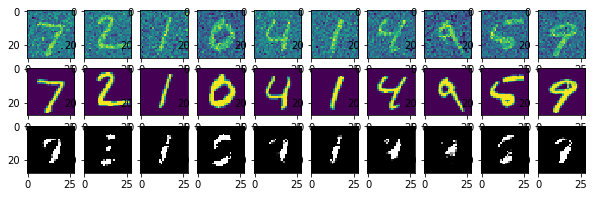

In [3]:
# 训练参数
training_epochs = 20  #一共迭代20次
batch_size = 256     #每次取256个样本
display_step = 5     #迭代5次输出一次信息
show_num = 10

# 启动绘话
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    # 开始训练
    for epoch in range(training_epochs):#迭代
        loss = 0.0
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)#取数据
            # 添加高斯噪音
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_size,n_input)
            # 从实验结果来看,加入 dropout 比不加 dropout 效果有明显提升,有噪音的数据适合加入dropout
            _, loss = sess.run([optimizer, cost], feed_dict={x: batch_xs_noisy,y:batch_xs,dropout_keep_prob:0.5})# 训练模型
        if epoch % display_step == 0:# 现实日志信息
            print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(loss))
    test_noisy = mnist.test.images[:show_num]+0.3*np.random.randn(show_num,n_input)
    reconstruction = sess.run(pred,feed_dict={x:test_noisy,dropout_keep_prob:1.0})
    f,a = plt.subplots(3,10,figsize=(10,3))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(test_noisy[i],(28,28)))
        a[1][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[2][i].imshow(np.reshape(reconstruction[i],(28,28)),cmap=plt.get_cmap('gray'))
    plt.show()

### 3 栈式自编码器

栈式自编码神经网络(stacked autoencoder, SA),是对自编码网络的一种使用方法,是一个由多层训练好的自编码器组成的神经网络.由于网络中的每一层都是单独训练而来的,相当于初始化了一个合理的数值.所以,这样的网络会更容易训练,并且有更快的收敛性及更高的准确度.

栈式自编码器常常被用于预训练(初始化)深度神经网络之前的权重预训练步骤,例如,在一个分类问题熵,可以按照从前向后的顺序执行每一层通过自编码器来训练,最终将网络中最深层的输出作为 softmax 分类器的输入特征,通过 softmax 层将其分开.

+ (1) 训练一个自编码器,得到原始输入的一阶特征表示 $h^{(1)}$ ,如图表示栈式自编码器的一层结构
<center><img src='./img/15/1.png' width="500"/></center><br/>

+ (2) 将上一步输出的特征 $h^{(1)}$ 作为输入,再进行一次自编码,并同时获取其特征 $h^{(2)}$,如图表示栈式自编码器的二层结构
<center><img src='./img/15/2.png' width="500"/></center><br/>

+ (3) 将上一步输出的特征 $h^{(2)}$ 连上 softmax 分类器,如图表示栈式自编码器的三层结构
<center><img src='./img/15/3.png' width="400"/></center><br/>

+ (4) 把这 3 层合并起来,就构成了一个包含两个隐含层加一个 softmax 的栈式自编码网络,它可以对数字图片分类,形成了一个栈式自编码器级联结构
<center><img src='./img/15/4.png' width="700"/></center><br/>

#### (1) 加载 MNIST 数据

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/mnist/",one_hot = True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


#### (2) 定义参数和占位符

In [5]:
# 科学的做法一般都是先重置整个计算图,建议这样做
tf.reset_default_graph()

# 定义网络参数
n_input    = 784 
n_hidden_1 = 256 #第一层自编码
n_hidden_2 = 128 #第二层自编码
n_classes  = 10

# 定义占位符
#第一层输入
x = tf.placeholder(dtype=tf.float32, shape = [None, n_input])
y = tf.placeholder(dtype=tf.float32, shape = [None, n_input])
dropout_keep_prob = tf.placeholder(dtype=tf.float32)
#第二层输入
l2x = tf.placeholder(dtype=tf.float32, shape = [None, n_hidden_1])
l2y = tf.placeholder(dtype=tf.float32, shape = [None, n_hidden_1]) 
#第三层输入
l3x = tf.placeholder(dtype=tf.float32, shape = [None, n_hidden_2])
l3y = tf.placeholder(dtype=tf.float32, shape = [None, n_classes])

#### (3) 定义权重

In [6]:
# 定义权重
weights = {
    #网络1  784-256-256-784
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'l1_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_1])),
    'l1_out': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #网络2  256-128-128-256
    'l2_h1': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'l2_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_2])),
    'l2_out': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    #网络3  128-10
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'l1_b2': tf.Variable(tf.zeros([n_hidden_1])),
    'l1_out': tf.Variable(tf.zeros([n_input])),
    
    'l2_b1': tf.Variable(tf.zeros([n_hidden_2])),
    'l2_b2': tf.Variable(tf.zeros([n_hidden_2])),
    'l2_out': tf.Variable(tf.zeros([n_hidden_1])),
    
    'out': tf.Variable(tf.zeros([n_classes]))
}

#### (4) 第一层网络结构

In [7]:
# 第一层的编码输出,输出的是 256 维
l1_out = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1'])) 
    
# 第一层的解码器模型
def noise_l1_autodecoder(layer_1, _weights, _biases, _keep_prob):
    layer_1out = tf.nn.dropout(layer_1, _keep_prob) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['l1_h2']), _biases['l1_b2'])) 
    layer_2out = tf.nn.dropout(layer_2, _keep_prob) 
    return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['l1_out']) + _biases['l1_out'])

# 第一层的解码输出
l1_reconstruction = noise_l1_autodecoder(l1_out, weights, biases, dropout_keep_prob)

# 计算损失
l1_cost = tf.reduce_mean(tf.pow(l1_reconstruction-y, 2))
# 定义优化器
l1_optm = tf.train.AdamOptimizer(0.01).minimize(l1_cost) 

#### (5) 第二层网络结构

In [8]:
# 第二层的编码输出
l2_out = tf.nn.sigmoid(tf.add(tf.matmul(l2x, weights['l2_h1']), biases['l2_b1'])) 

# 第二层的解码器模型
def l2_autodecoder(layer1_2, _weights, _biases):
    layer1_2out = tf.nn.sigmoid(tf.add(tf.matmul(layer1_2, _weights['l2_h2']), _biases['l2_b2'])) 
    return tf.nn.sigmoid(tf.matmul(layer1_2out, _weights['l2_out']) + _biases['l2_out'])

# 第二层的解码输出
l2_reconstruction = l2_autodecoder(l2_out, weights, biases)

# 计算损失
l2_cost = tf.reduce_mean(tf.pow(l2_reconstruction-l2y, 2))
# 定义优化器
optm2 = tf.train.AdamOptimizer(0.01).minimize(l2_cost) 

#### (6) 第三层网络结构

In [9]:
# 第三层分类
l3_out = tf.matmul(l3x, weights['out']) + biases['out']
l3_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=l3_out, labels=l3y))
l3_optm = tf.train.AdamOptimizer(0.01).minimize(l3_cost)

#### (7) 定义级联网络结构

In [10]:
#3层 级联
# 1联2,也就是 256-128
l1_l2out = tf.nn.sigmoid(tf.add(tf.matmul(l1_out, weights['l2_h1']), biases['l2_b1'])) 
# 2联3, 也就是 128-10
pred = tf.matmul(l1_l2out, weights['out']) + biases['out']
# 定义优化器
cost3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=l3y))
optm3 = tf.train.AdamOptimizer(0.001).minimize(cost3)

#### (8) 定义训练参数

In [11]:
epochs     = 50
batch_size = 100
disp_step  = 10
load_epoch = 49

#### (9) 第一层网络训练

Epoch 00/50 average cost: 0.112775
Epoch 10/50 average cost: 0.035776
Epoch 20/50 average cost: 0.033274
Epoch 30/50 average cost: 0.032324
Epoch 40/50 average cost: 0.031713


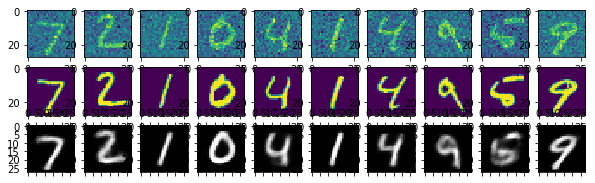

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        num_batch  = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # 对于有噪音的数据,通常需要在全连接层中加入 dropout
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_size, 784)
            feeds = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 0.5}
            sess.run(l1_optm, feed_dict=feeds)
            total_cost += sess.run(l1_cost, feed_dict=feeds)
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))

    show_num = 10
    test_noisy = mnist.test.images[:show_num] + 0.3*np.random.randn(show_num, 784)
    encode_decode = sess.run(
        l1_reconstruction, feed_dict={x: test_noisy, dropout_keep_prob: 1.})
    f, a = plt.subplots(3, 10, figsize=(10, 3))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(test_noisy[i], (28, 28)))
        a[1][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[2][i].matshow(np.reshape(encode_decode[i], (28, 28)), cmap=plt.get_cmap('gray'))
    plt.show()


#### (10) 第二层网络训练

Epoch 00/50 average cost: 0.139380
Epoch 10/50 average cost: 0.056537
Epoch 20/50 average cost: 0.051679
Epoch 30/50 average cost: 0.050478
Epoch 40/50 average cost: 0.050280


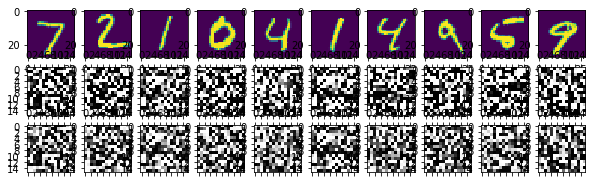

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        num_batch  = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # 为了训练第二层网络,需要先将第一层的数据拿出来,再进行训练
            l1_h = sess.run(l1_out, feed_dict={x: batch_xs, y: batch_xs, dropout_keep_prob: 1.})
            _,l2cost = sess.run([optm2,l2_cost], feed_dict={l2x: l1_h, l2y: l1_h })
            total_cost += l2cost

        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))
    show_num = 10
    testvec = mnist.test.images[:show_num]
    out1vec = sess.run(l1_out, feed_dict={x: testvec,y: testvec, dropout_keep_prob: 1.})
    out2vec = sess.run(l2_reconstruction, feed_dict={l2x: out1vec})

    f, a = plt.subplots(3, 10, figsize=(10, 3))
    for i in range(show_num):
        a[0][i].imshow(np.reshape(testvec[i], (28, 28)))
        a[1][i].matshow(np.reshape(out1vec[i], (16, 16)), cmap=plt.get_cmap('gray'))
        a[2][i].matshow(np.reshape(out2vec[i], (16, 16)), cmap=plt.get_cmap('gray'))
    plt.show()

#### (11) 第三层网络训练

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        num_batch  = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)    
            # 要将前面训练的两层数据拿出来,作为第三个训练的输入
            l1_h = sess.run(l1_out, feed_dict={x: batch_xs, y: batch_xs, dropout_keep_prob: 1.})               
            l2_h = sess.run(l2_out, feed_dict={l2x: l1_h, l2y: l1_h })
            _,l3cost = sess.run([l3_optm,l3_cost], feed_dict={l3x: l2_h, l3y: batch_ys})
            total_cost += l3cost
            
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))
    # 测试 model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(l3y, 1))
    # 计算准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print ("Accuracy:", accuracy.eval({x: mnist.test.images, l3y: mnist.test.labels}))

Epoch 00/50 average cost: 2.220234
Epoch 10/50 average cost: 0.717387
Epoch 20/50 average cost: 0.713068
Epoch 30/50 average cost: 0.708088
Epoch 40/50 average cost: 0.711338
Accuracy: 0.78


#### (12) 级联微调

In [15]:
# 将图片分类模型联合起来,主要用于级联网络
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        num_batch  = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            feeds = {x: batch_xs, l3y: batch_ys}
            sess.run(optm3, feed_dict=feeds)
            total_cost += sess.run(cost3, feed_dict=feeds)
        # DISPLAY
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))
    # 测试 model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(l3y, 1))
    # 计算准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print ("Accuracy:", accuracy.eval({x: mnist.test.images, l3y: mnist.test.labels}))

Epoch 00/50 average cost: 1.519638
Epoch 10/50 average cost: 0.073526
Epoch 20/50 average cost: 0.010531
Epoch 30/50 average cost: 0.001283
Epoch 40/50 average cost: 0.003417
Accuracy: 0.9568
